In [1]:
%matplotlib ipympl
# % matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
#plt.style.use('seaborn')

from scipy import stats

#### Data Opening Functions

In [2]:
def data_opening_w_stripe(stripe, d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')  

    # FOR FUV A SWP
    if 'ICON_L1_FUVA_SWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        # Rename and drop useless variables
        dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    
    # FOR FUV B LWP
    elif 'ICON_L1_FUVB_LWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVB_LWP_Center_Times','ICON_L1_FUVB_LWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVB_LWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        #  Rename and drop useless variables
        dsf['N2'] = dsf['ICON_L1_FUVB_LWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVB_LWP_PROF_'+str(stripe),'ICON_L1_FUVB_LWP_Center_Times','Epoch'])    
      
    return dsf

#### Orbit Separation Functions

In [3]:
def orbits_finder(df):
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [4]:
def orbits_finder_lw(starts,ends, df):
    data = df.N2.mean(dim = 'row')
    data_np = data.to_numpy()

    all_orbits = []
    for i in range(0,len(starts)):
        df_orbit = df.sel(time=slice(starts[i], ends[i]))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [5]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    
    if 'I_1356' in orb.variables.keys():
        val = orb.I_1356
    elif 'N2' in orb.variables.keys():
        val = orb.N2
        
    return(t, val)

#### Raw Counts Plot

In [6]:
def stripes_lineplot(n,day):
    plt.figure(figsize = (9,10))
    plt.title("Comparing Stripes of FUV Data for Orbit "+str(n)+ " on " + day +" 2020")

    plt.plot(single_orb(swp_p0_all,n)[0],single_orb(swp_p0_all,n)[1],marker = '.', label = 'PO SWP')
    plt.plot(single_orb(swp_p3_all,n)[0],single_orb(swp_p3_all,n)[1],marker = '.', label = 'P3 SWP')
    plt.plot(single_orb(swp_p6_all,n)[0],single_orb(swp_p6_all,n)[1],marker = '.', label = 'P6 SWP')
    plt.plot(single_orb(swp_m3_all,n)[0],single_orb(swp_m3_all,n)[1],marker = '.', label = 'M3 SWP')
    plt.plot(single_orb(swp_m6_all,n)[0],single_orb(swp_m6_all,n)[1],marker = '.', label = 'M6 SWP')
    plt.plot(single_orb(swp_m9_all,n)[0],single_orb(swp_m9_all,n)[1],marker = '.', label = 'M9 SWP')

    # plt.plot(single_orb(lwp_p0_all,n)[0],single_orb(lwp_p0_all,n)[1],marker = '.', label = 'PO LWP')
    # plt.plot(single_orb(lwp_p3_all,n)[0],single_orb(lwp_p3_all,n)[1],marker = '.', label = 'P3 LWP')
    # plt.plot(single_orb(lwp_p6_all,n)[0],single_orb(lwp_p6_all,n)[1],marker = '.', label = 'P6 LWP')
    # plt.plot(single_orb(lwp_m3_all,n)[0],single_orb(lwp_m3_all,n)[1],marker = '.', label = 'M3 LWP')
    # plt.plot(single_orb(lwp_m6_all,n)[0],single_orb(lwp_m6_all,n)[1],marker = '.', label = 'M6 LWP')
    # plt.plot(single_orb(lwp_m9_all,n)[0],single_orb(lwp_m9_all,n)[1],marker = '.', label = 'M9 LWP')

    plt.legend()
    plt.show()


#### FUV Plot

In [7]:
def fuv_plots_smoothed(orbit_data,day,orbit_num):
    
    if 'I_1356' in orbit_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        orbit_data['I_1356_filt'] = orbit_data['I_1356'] - orbit_data['I_1356'].rolling(time=17, center=True).mean() 
        orbit_data['I_1356_filt'] = orbit_data['I_1356_filt'].rolling(time=3, center=True).mean()

        # FUV Plot
        plt.figure(figsize=(10,3))
        #vm = abs(orbit_data.I_1356_filt).quantile(0.95) 
        vm = 60
        plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
        plt.ylabel('Row')
        plt.colorbar(label='R')
        plt.title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})')

        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
        
    elif 'N2' in orbit_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        orbit_data['N2_filt'] = orbit_data['N2'] - orbit_data['N2'].rolling(time=17, center=True).mean()
        orbit_data['N2_filt'] = orbit_data['N2_filt'].rolling(time=3, center=True).mean()
        # FUV Plot
        plt.figure(figsize=(10,3))
        #vm = abs(orbit_data.N2_filt).quantile(0.95) 
        vm = 15
        plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.N2_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
        plt.ylabel('Row')
        plt.colorbar(label='R')
        plt.title(f'FUV LWP N2 on {day} (Orbit {orbit_num})')
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
          
    #fig_name = f'raw_fuv{day}_orbit{orbit_num}'
    #plt.savefig(fig_name)
        

In [8]:
def both_fuvs(day,n):
    swp = orbits_finder(swp_p0)[n]
    lwp = orbits_finder_lw(orbits_finder_more_returns(swp_p0)[0],orbits_finder_more_returns(swp_p0)[1],lwp_p0)[n]
    fuv_plots_smoothed(swp,str(day), str(n))
    fuv_plots_smoothed(lwp,str(day), str(n))
    

#### Goal: Figure out feature Wavelengths

In [9]:
L1f_swp_05 = 'ICON_L1_FUV_SWP_2020-05-10_v05r000.NC'

In [10]:
# ALL STRIPES FOR SWP
swp_m9 = data_opening_w_stripe('M9',L1f_swp_05)
swp_m6 = data_opening_w_stripe('M6',L1f_swp_05)
swp_m3 = data_opening_w_stripe('M3',L1f_swp_05)
swp_p0 = data_opening_w_stripe('P0',L1f_swp_05)
swp_p3 = data_opening_w_stripe('P3',L1f_swp_05)
swp_p6 = data_opening_w_stripe('P6',L1f_swp_05)

# ALL 
swp_p0_all = orbits_finder(swp_p0)
swp_p3_all = orbits_finder(swp_p3)
swp_p6_all = orbits_finder(swp_p6)
swp_m3_all = orbits_finder(swp_m3)
swp_m6_all = orbits_finder(swp_m6)
swp_m9_all = orbits_finder(swp_m9)

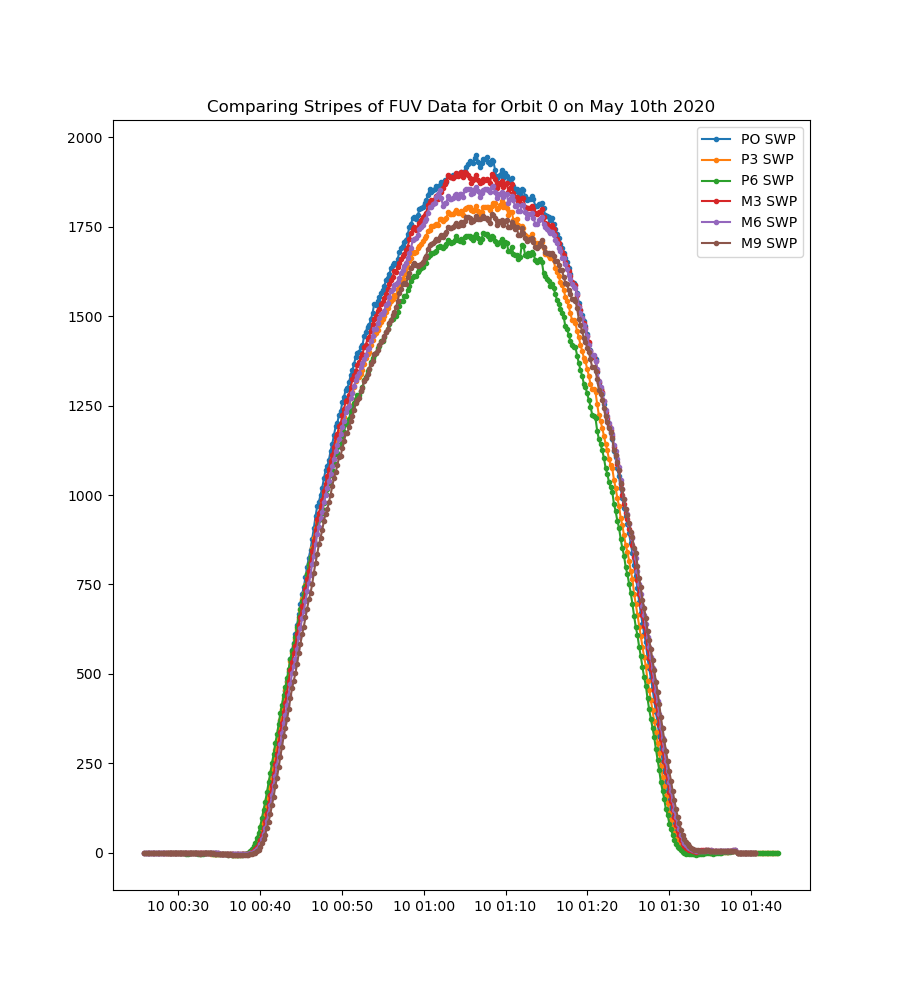

In [11]:
stripes_lineplot(0,'May 10th')

#### IDEA: FT the 1d signals, find the frequencies for all the orbits 

In [12]:
from scipy.fft import fft, fftfreq, fftshift

In [13]:
def ft_data(n):
    x_data_o, y_data = single_orb(swp_p0_all,n)
   
    x_data = x_data_o.values.astype('float64')
    y_data = y_data.values

    # FT THIS
    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), x_data[0]- x_data[1])
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)
    

    #Max Val 
    max_index = np.argmax(np.abs(shifted_transformed)) 
    #print('index',max_index)
    max_val = shifted_freqs[max_index]
    #print('val', np.abs(max_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
    
    ax1.plot(x_data_o, y_data,marker = '.', label = 'PO SWP Original')
    ax1.set_title('Original Data (Brightness) for Orbit '+str(n)+' \n Sept 24th for SWP P0')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Brightness')
    ax1.tick_params(axis='x', labelrotation = 45)
    
    ax2.plot(shifted_freqs, np.abs(shifted_transformed))
    ax2.set_title('Fourier Transform for Orbit '+str(n)+' \n Sept 24th for SWP P0')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()    

In [14]:
def fuv_line_plots_ft(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # Percentage Change
    swp_sel_rows['Percentage_Change'] = ((swp_sel_rows['I_1356_filt'])/np.abs(swp_sel_rows['I_1356'])) *100


    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))

    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Scaled
    #scaled = shifted_freqs * 12*7.5
    
    
    # INITIALIZE PLOTS
    #(fig, ((ax1,ax2),(ax3,ax4))) = plt.subplots(2, 2, figsize = (15,8))
    (fig, (ax1,ax2,ax3,ax4)) = plt.subplots(4, 1, figsize = (10,15))

    # FUV 1- SWP RAW
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})\n Samples: {nsamples}')  

    # FUV 2- SWP PERCENTS
    vm_2 = 3 # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.Percentage_Change.T, cmap='plasma',vmin=-vm_2, vmax=vm_2)
    ax2.set_ylabel('Row')
    fig.colorbar(pcm_2, ax = ax2, label='% Change')
    ax2.set_title(f'FUV SWP Percentage Change on {day} (Orbit {orbit_num})\n Samples: {nsamples}')  

    
    # Line Plot
    ax3.set_title(f'FUV brightness on {day} (Orbit {orbit_num})')
    ax3.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
    ax3.set_ylabel ("FUV Brightness")
    ax3.legend()


    # FT Plot
    ax4.plot(shifted_freqs, np.abs(shifted_transformed))
    ax4.set_title('Fourier Transform for Orbit '+str(orbit_num)+' \n' + str(day) + ' for SWP P0')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Amplitude')
    
    plt.tight_layout()

    #fig_name = f'corr_fuv_lineplot_{day}_orbit{orbit_num}'
    #plt.savefig(fig_name)
    



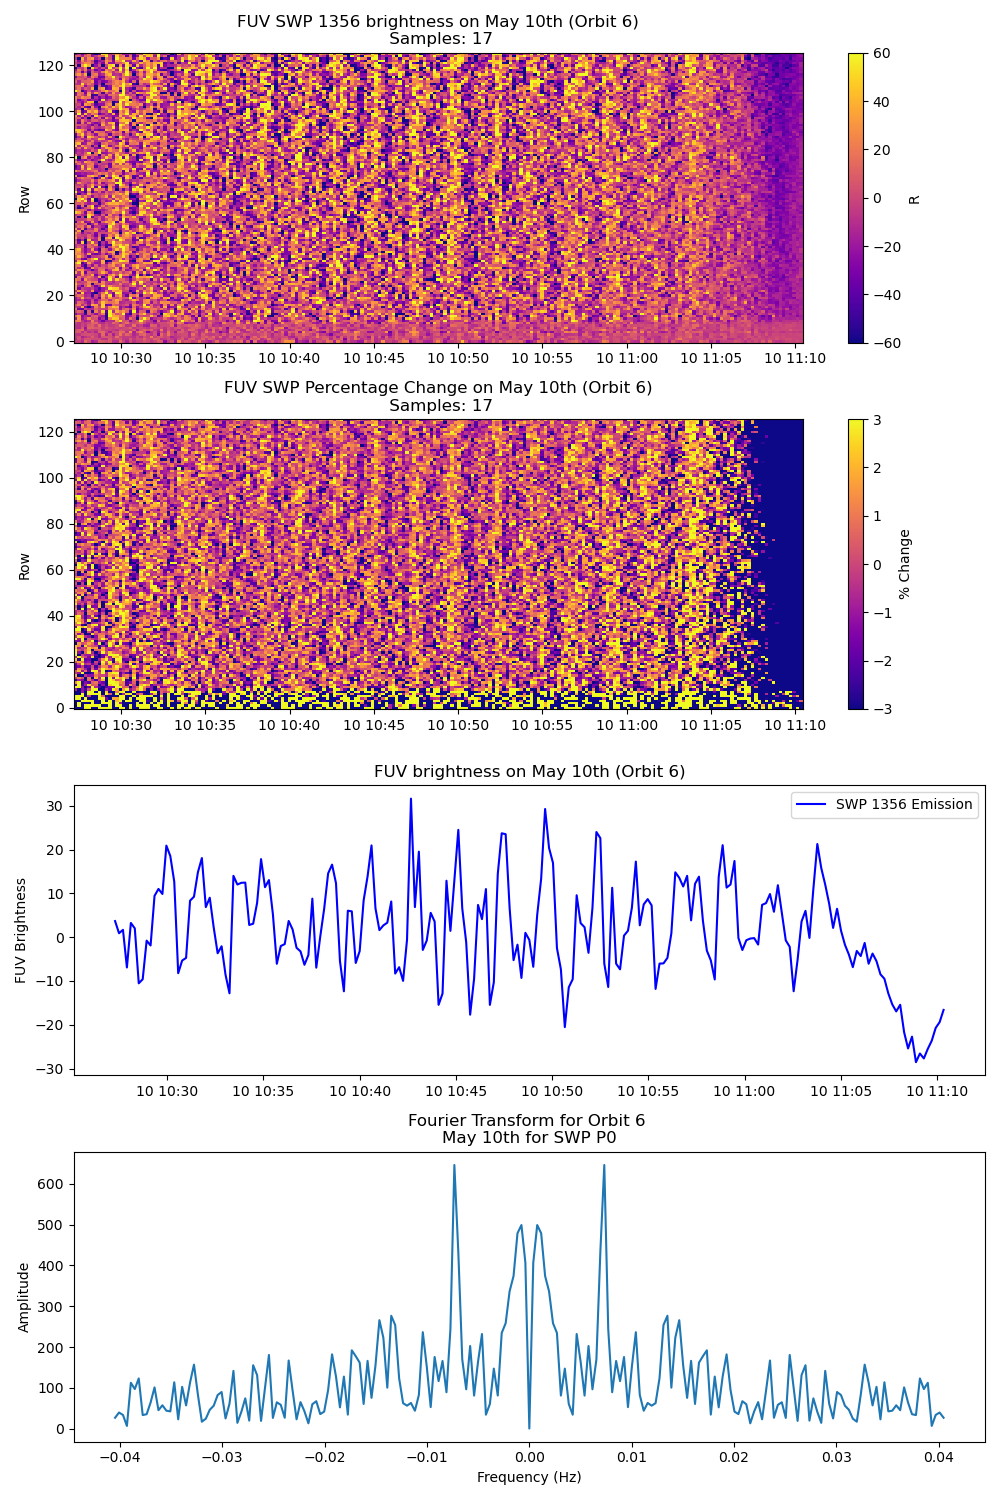

In [18]:
swp = orbits_finder(swp_p0)[6]
fuv_line_plots_ft(swp,'May 10th',6,17)

In [123]:
def wavelength_plots(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))

    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Scaled
    #scaled = shifted_freqs * 12*7.5
    
    
    # INITIALIZE PLOTS
    #(fig, ((ax1,ax2),(ax3,ax4))) = plt.subplots(2, 2, figsize = (15,8))
    (fig, (ax1,ax2,ax3)) = plt.subplots(3, 1, figsize = (10,15))

    # FUV 1- SWP RAW
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})\n Samples: {nsamples}')  

    
    # Line Plot
    ax2.set_title(f'FUV brightness on {day} (Orbit {orbit_num})')
    ax2.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
    ax2.set_ylabel ("FUV Brightness")
    ax2.legend()

    
    # Find Peak
    from scipy.signal import find_peaks
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    max_data = max(y)

    indices = find_peaks(y, height = max_data * 1/2) 

    indexes = indices[0]

    times = []
    vals_at_times = []
    for i in indexes: 
        times.append(x[i])
        vals_at_times.append(y[i])
    
    peak_times = []
    peak_vals = []
    
    for i in range(0,len(times)):
        if times[i] >= 0.005 or times[i] <= -0.005:
            peak_times.append(times[i])
            peak_vals.append(vals_at_times[i])
        
    # FT Plot w Peaks
    ax3.plot(shifted_freqs, np.abs(shifted_transformed))
    ax3.set_title('Fourier Transform for Orbit '+str(orbit_num)+' \n' + str(day) + ' for SWP P0')
    
    for i in range(0,len(peak_times)):
        ax3.plot(peak_times[i],peak_vals[i],'ro', markersize = 5)
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Amplitude')
       
    
    # Freq to Wavelength
    dist_peak = []
    
    for f in peak_times:
        if f > 0: # just taking positive so I get one value
            dist_peak.append(1/f * 7.5)

    plt.tight_layout()

    return dist_peak

    #fig_name = f'corr_fuv_lineplot_{day}_orbit{orbit_num}'
    #plt.savefig(fig_name)
    



[1024.1273684210528]

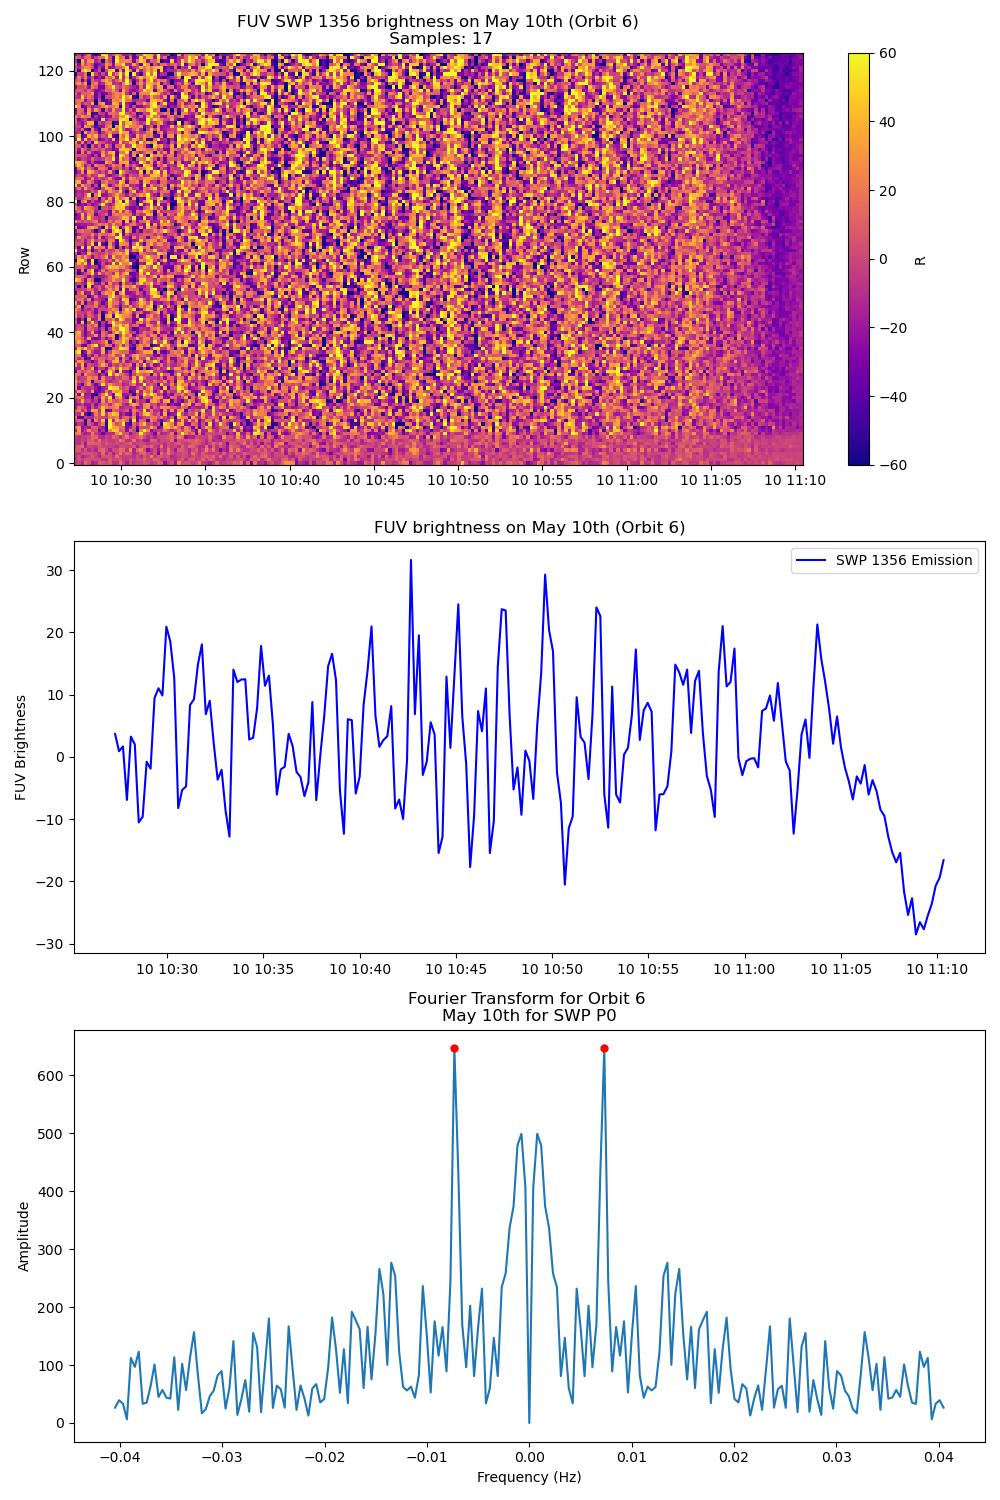

In [124]:
swp = orbits_finder(swp_p0)[6]
wavelength_plots(swp,'May 10th',6,17)

[1024.8769683536843]

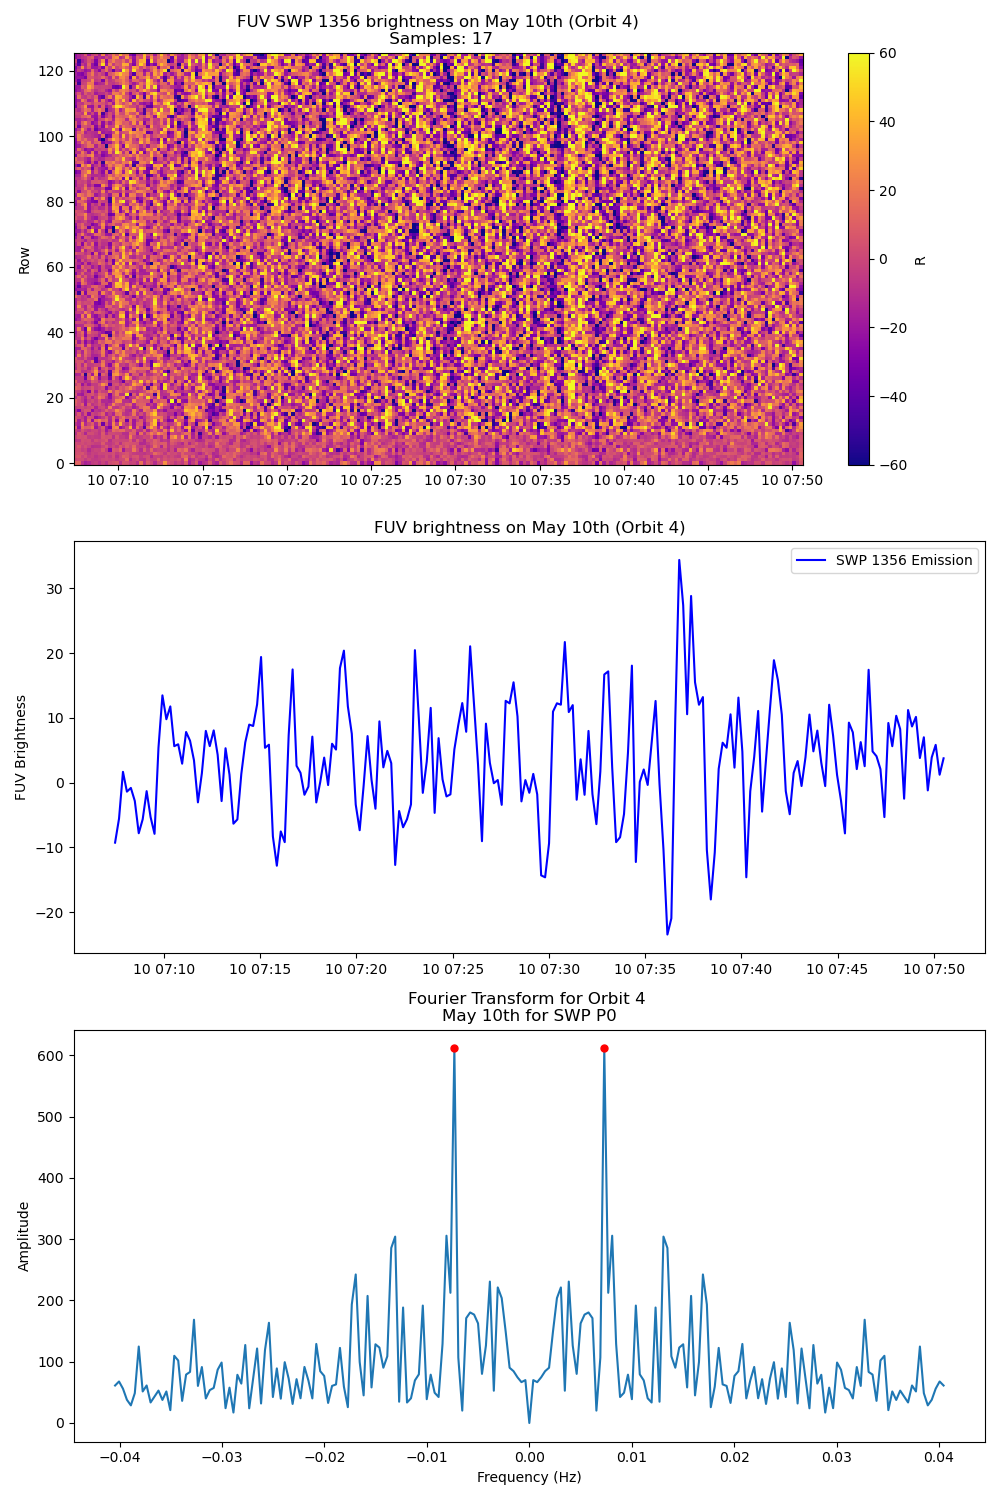

In [125]:
swp = orbits_finder(swp_p0)[4]
wavelength_plots(swp,'May 10th',4,17)

In [ ]:
# loop thru a bunch of different orbits (histogram)

[512.0636842105264, 1024.1273684210528]

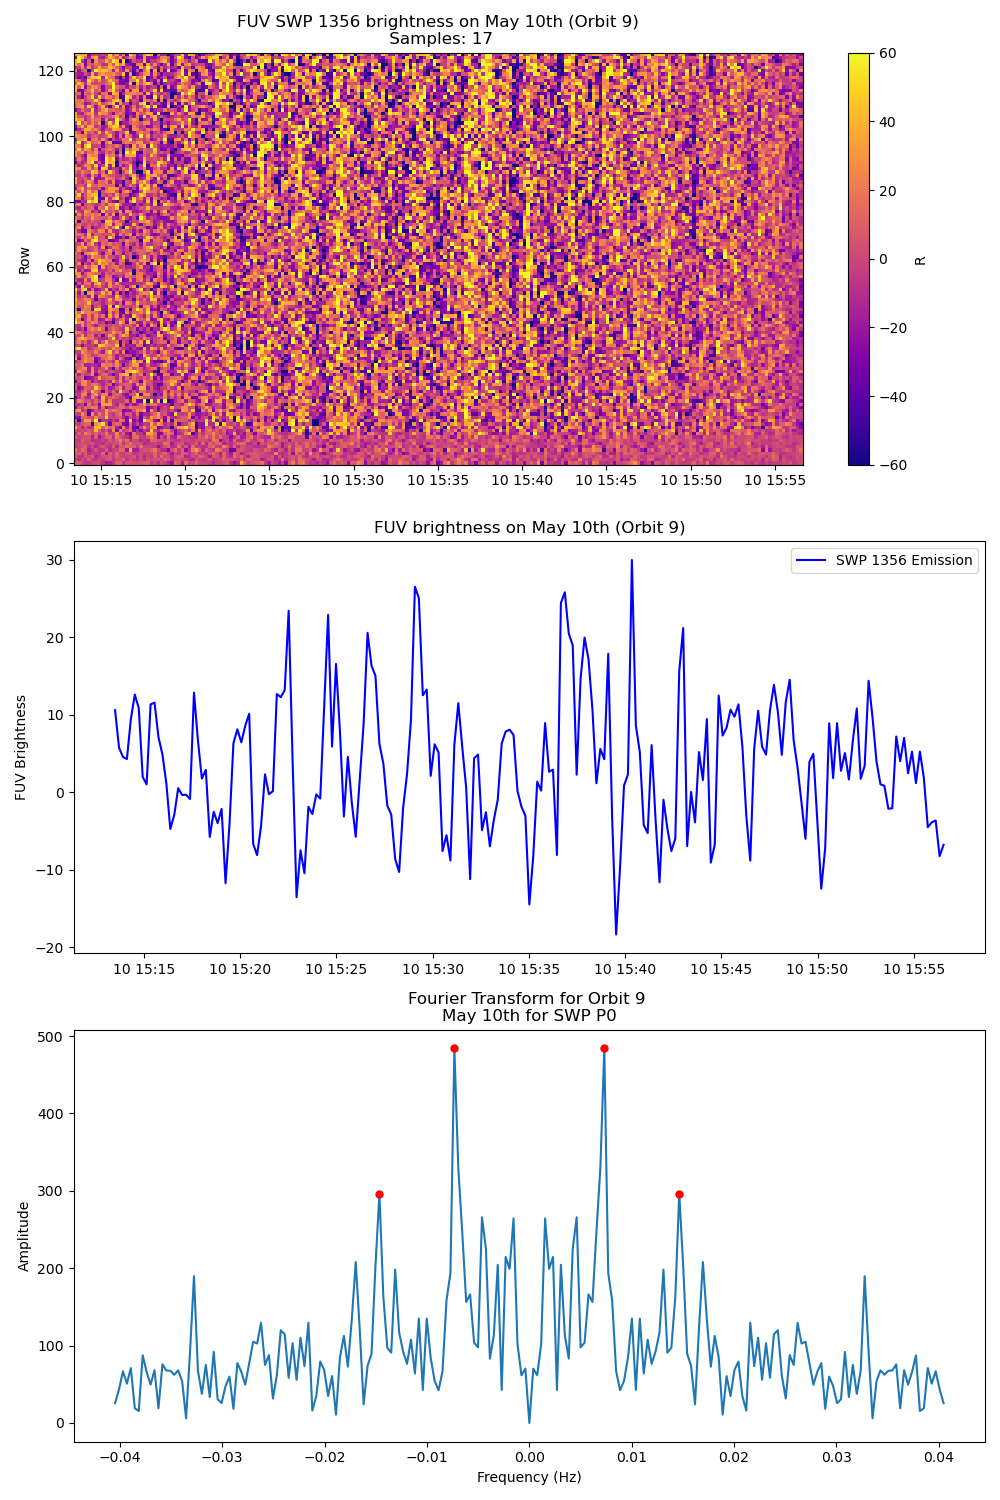

In [126]:
swp = orbits_finder(swp_p0)[9]
wavelength_plots(swp,'May 10th',9,17)

[463.2957142857144, 512.0636842105264, 1024.1273684210528]

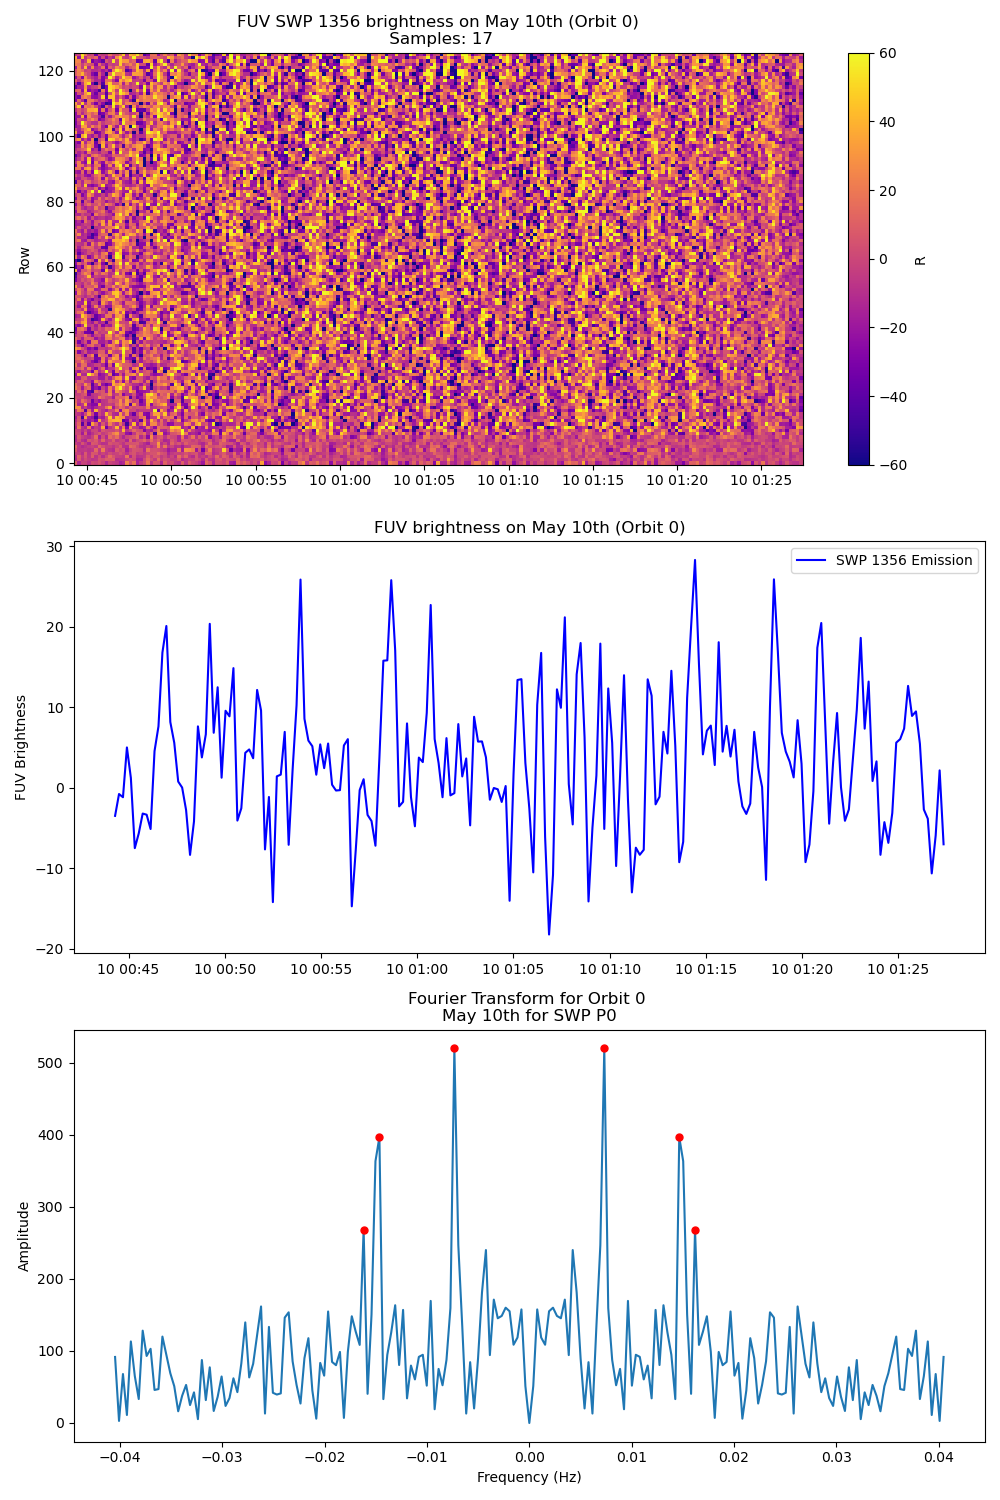

In [127]:
swp = orbits_finder(swp_p0)[0]
wavelength_plots(swp,'May 10th',0,17)

In [ ]:
# sanity check- remove everything except for peaks of interest, keep both real and imaginary, and ifft 
# should get a sinusoid, overlay that on original data to see if it aligns

In [155]:
def dominant_wavelength_finder(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))
    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Find Peak
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    
    limited_indexes = []

    for i in range(0,len(x)):
        if x[i] >= 0.005 or x[i] <= -0.005:
            limited_indexes.append(i)
    
    times = []
    vals_at_times = []
    
    for j in limited_indexes:
        times.append(x[j])
        vals_at_times.append(y[j])
           
    max_index_pos = 0
    y_max_pos = 0

    for i in range(0,len(times)):
        if times[i] > 0 and vals_at_times[i] > y_max_pos:
            y_max_pos = vals_at_times[i]
            max_index_pos = i
        
    # Freq to Wavelength
    dist_peak = (1/x[max_index_pos] * 7.5)

    return dist_peak,day,orbit_num


In [153]:
def wavelength_plots(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))

    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Scaled
    #scaled = shifted_freqs * 12*7.5
    
    
    # INITIALIZE PLOTS
    #(fig, ((ax1,ax2),(ax3,ax4))) = plt.subplots(2, 2, figsize = (15,8))
    (fig, (ax1,ax2,ax3)) = plt.subplots(3, 1, figsize = (10,15))

    # FUV 1- SWP RAW
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})\n Samples: {nsamples}')  

    
    # Line Plot
    ax2.set_title(f'FUV brightness on {day} (Orbit {orbit_num})')
    ax2.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
    ax2.set_ylabel ("FUV Brightness")
    ax2.legend()

    
    # Find Peak
    from scipy.signal import find_peaks
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    
    limited_indexes = []

    for i in range(0,len(x)):
        if x[i] >= 0.005 or x[i] <= -0.005:
            limited_indexes.append(i)
    
    times = []
    vals_at_times = []
    
    for j in limited_indexes:
        times.append(x[j])
        vals_at_times.append(y[j])
           
    max_index_neg = 0
    y_max_neg = 0

    max_index_pos = 0
    y_max_pos = 0

    for i in range(0,len(times)):
        if times[i] < 0 and vals_at_times[i] > y_max_neg:
            y_max_neg = vals_at_times[i]
            max_index_neg = i
        
        if times[i] > 0 and vals_at_times[i] > y_max_pos:
            y_max_pos = vals_at_times[i]
            max_index_pos = i
    
    # FT Plot w Peaks
    ax3.plot(shifted_freqs, np.abs(shifted_transformed))
    ax3.set_title('Fourier Transform for Orbit '+str(orbit_num)+' \n' + str(day) + ' for SWP P0')
    ax3.plot(x[max_index_pos],y_max_pos,'ro', markersize = 5)
    ax3.plot(x[max_index_neg],y_max_neg,'ro', markersize = 5)

    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Amplitude')
       
    
    # Freq to Wavelength
    dist_peak = (1/x[max_index_pos] * 7.5)

    plt.tight_layout()

    return dist_peak

    #fig_name = f'corr_fuv_lineplot_{day}_orbit{orbit_num}'
    #plt.savefig(fig_name)

1024.1273684210528

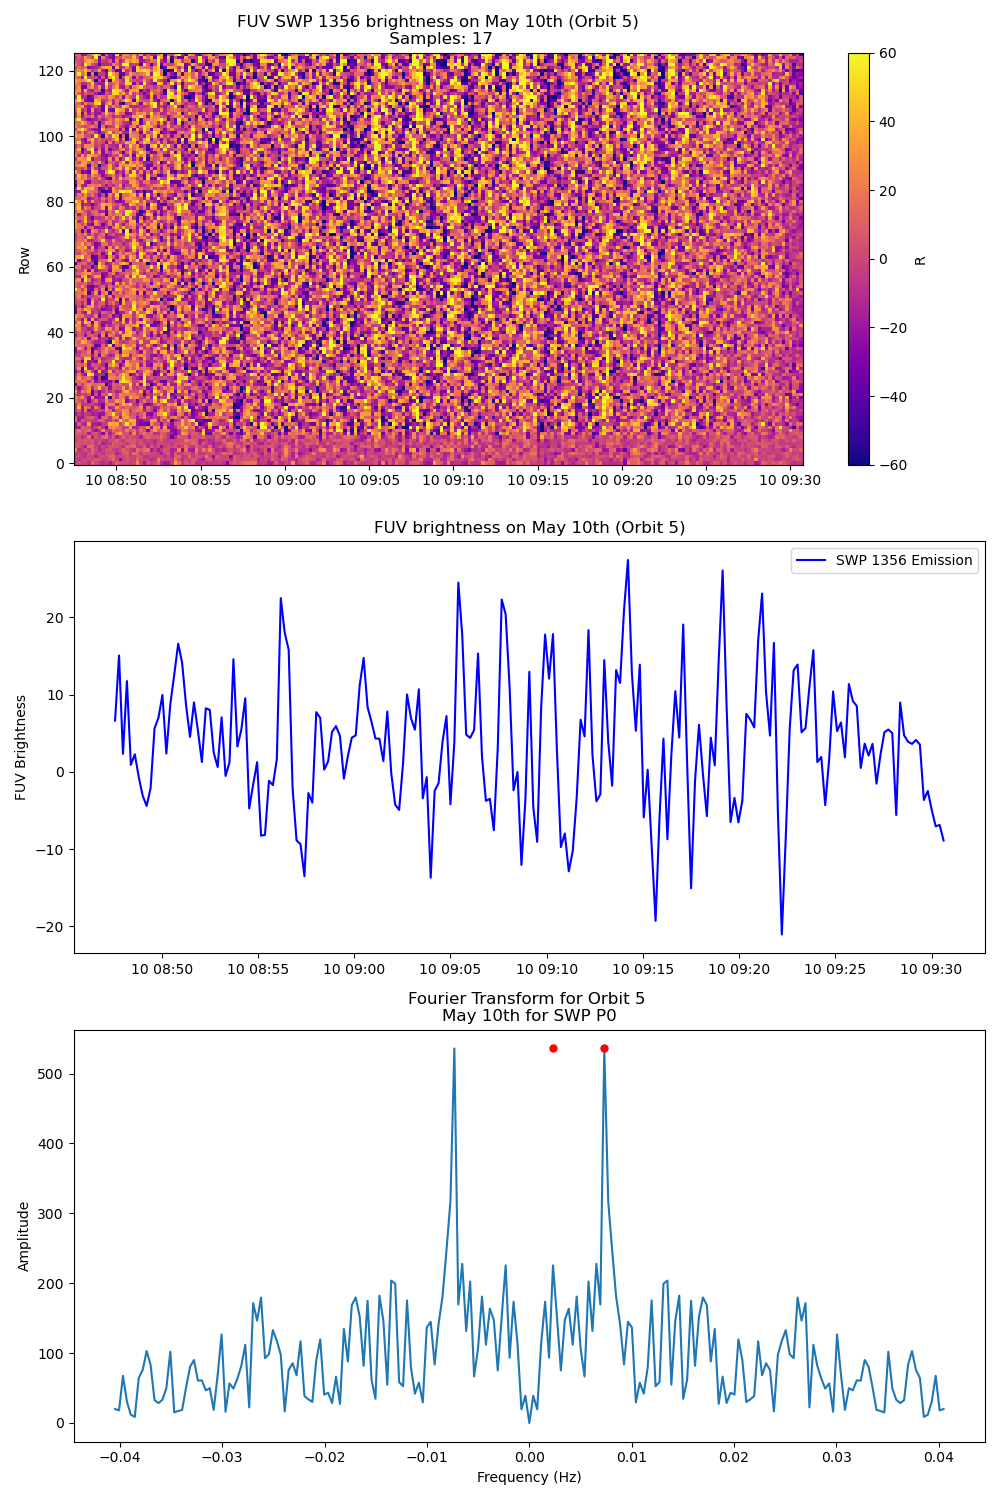

In [154]:
swp = orbits_finder(swp_p0)[5]
wavelength_plots(swp,'May 10th',5,17)